## Lab 14b: Markov Decision Processes (MDPs) and Value Iteration
`Lab 14b` will familiarize students with using `value iteration` for solving a two-dimensional grid-world navigation task. Suppose you have a [roomba](https://www.irobot.com) that has finished cleaning the floor in your kitchen and needs to return to its charging station (where it receives a positive reward). However, between your kitchen and the `charging station` (home base and safety), there are one or more `lava pits` (destruction for the [roomba](https://www.irobot.com), large negative reward). 

* __Task 1__: Setup a $n_{r}\times{n}_{c}$ grid, encode this model as an instance of the `MyRectangularGridWorldModel` type, build this instance using a `build(...)` method.
    * `TODO`: Inspect the data inside our grid world model, understand what each describes
* __Task 2__: Use the `MyRectangularGridWorldModel` instance and generate the components of the `MDP,` namely, the return function (or array) `R(s, a),` and the model of the physics of the world in the transition function (or array) `T(s′, s, a).`
* __Task 3__: Use a `value iteration` method to estimate the optimal value function $U^{\star}(s)$
    * `TODO`: Extract the `action-value function` or $Q(s, a)$ from the optimal optimal value function $U^{\star}(s)$ 
    * `TODO`: Compute the optimal navigation policy $\pi^{\star}(s)$ from $Q(s,a)$
    * `TODO`: Visualize the optimal policy

### Background
In an MDP, an agent receives a reward or penalty for each decision. MDPs consist of the tuple $\left(\mathcal{S}, \mathcal{A}, R_{a}\left(s, s^{\prime}\right), T_{a}\left(s,s^{\prime}\right), \gamma\right)$:

* The state space $\mathcal{S}$ is the set of all possible states $s$ that a system can exist in.
* The action space $\mathcal{A}$ is the set of all possible actions $a$ that are available to the agent, where $\mathcal{A}_{s} \subseteq \mathcal{A}$ is the subset of the action space $\mathcal{A}$ that is accessible from state $s$.
* An reward $R_{a}\left(s, s^{\prime}\right)$ is received after transitioning from $s\rightarrow{s}^{\prime}$ due to action $a$. 
* The state transition model $T_{a}\left(s,s^{\prime}\right) = P(s_{t+1} = s^{\prime}~|~s_{t}=s,a_{t} = a)$ denotes the probability that action $a$ in state $s$ at time $t$ will result in state $s^{\prime}$ at time $t+1$
* The quantity $\gamma$ is a discount factor used to weigh the future expected utility.

Finally, a policy function $\pi$ is the mapping from states $s\in\mathcal{S}$ to actions $a\in\mathcal{A}$ used by the agent to solve a decision task, i.e., $\pi(s) = a$. 
_Value iteration_ computes the optimal value function $U^{\star}$ (and from that we get an optimal policy $\pi^{\star}$) using the _Bellman backup_ operation:

$$
\begin{equation*}
U_{k+1}(s) = \underset{a\in\mathcal{A}}{\max}\left(R(s,a) + \gamma\cdot\sum_{s^{\prime}\in\mathcal{S}}T(s^{\prime}\,\vert\,s,a)\cdot{U}_{k}(s^{\prime})\right)\quad\forall{s}\in\mathcal{S}
\end{equation*}
$$

As $k\rightarrow\infty$ the value function converges $U_{k}(s)\rightarrow{U^{\star}(s)}$.
The optimal policy $\pi^{\star}(s)$ can then extracted from the optimal $\texttt{action-value}$ function $Q^{\star}(s,a)$:

$$
\begin{equation*}
Q^{\star}(s,a) = R(s,a) + \gamma\cdot\sum_{s^{\prime}\in\mathcal{S}}T(s^{\prime}\,\vert\,s,a)\cdot{U^{\star}}(s^{\prime})\quad\forall{s\in\mathcal{S},a\in\mathcal{A}}
\end{equation*}
$$
by selecting the action $a\in\mathcal{A}$ such that:
$$
\begin{equation*}
\pi^{\star}(s) = \underset{a\in\mathcal{A}}{\arg\max}\,Q^{\star}(s,a)\quad\forall{s\in\mathcal{S}}
\end{equation*}
$$

## Setup
The computations in this lab (or example) are enabled by codes in the [src](src) directory and several external `Julia` packages. To load the required packages and any custom codes the teaching team has developed to work with these packages, we [include](https://docs.julialang.org/en/v1/manual/code-loading/) the `Include.jl` file):

In [1]:
include("Include.jl");

  Activating project at `~/Desktop/julia_work/CHEME-4800-5800-Labs-AY-2024/week-14/Lab-14b`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Labs-AY-2024/week-14/Lab-14b/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Labs-AY-2024/week-14/Lab-14b/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Labs-AY-2024/week-14/Lab-14b/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Labs-AY-2024/week-14/Lab-14b/Manifest.toml`


## Task 1: Build the world model
We encoded the `rectangular grid world` using the `MyRectangularGridWorldModel` model, which we constructed using a `build(...)` method. Let's set up the data for the world, set up the states, actions, and rewards, and then construct the world model. 
* First, set values for the `number_of_rows` and `number_of_cols` variables, the `nactions` available to the agent, and the `discount factor` $\gamma$. Then, we'll compute the number of states and set the state set $\mathcal{S}$ and the action set $\mathcal{A}$

In [2]:
number_of_rows = 20
number_of_cols = 20
nactions = 4;
γ = 0.95;
nstates = (number_of_rows*number_of_cols);
𝒮 = range(1,stop=nstates,step=1) |> collect;
𝒜 = range(1,stop=nactions,step=1) |> collect;

Next, we'll set up a description of the rewards, the `rewards::Dict{Tuple{Int, Int}, Float64}` dictionary, which maps the $(x,y)$-coordinates to a reward value. 
* We only need to put `non-default` reward values in the reward dictionary (we'll add default values to the other locations later). Also, let's put the locations on the grid that are `absorbing,` meaning the charging station or lava pits in your living room, in the `absorbing_state_set` variable. In addition to the `lava` and `charging station,` the `absorbing_state_set` could include spots where Roomba gets stuck.
* The `soft_wall_set` set includes locations (states) that Roomba can access, e.g., where there is furniture. For now, let's leave the `soft_wall_set` empty.

In [3]:
# setup rewards -
lava_reward = -10000.0;
charging_reward = 100.0

rewards = Dict{Tuple{Int,Int}, Float64}()
rewards[(1,2)] = lava_reward # lava in the (1,2) square 
rewards[(2,2)] = lava_reward # lava in the (2,2) square 
rewards[(2,3)] = lava_reward # lava in the (2,3) square 
rewards[(4,5)] = lava_reward # lava in the (4,4) square
rewards[(18,10)] = charging_reward   # charging station square

# Setup set of absorbing states (all lava pits and the charging station absorb)
absorbing_state_set = Set{Tuple{Int,Int}}()
for (k,v) ∈ rewards
    push!(absorbing_state_set, k);   
end

# Setup soft walls (constraints) -
soft_wall_set = Set{Tuple{Int,Int}}();

Finally, build an instance of the `MyRectangularGridWorldModel` type, which models the grid world:
* We pass in the number of rows `nrows,` the number of cols `ncols,` and our initial reward description in the `rewards` field into the `build(...)` method. This method then transforms this data into the fields of the `MyRectangularGridWorldModel` model. Save the world model in the `world` variable:

In [4]:
world = build(MyRectangularGridWorldModel, 
    (nrows = number_of_rows, ncols = number_of_cols, rewards = rewards));

#### Questions
* `TODO`: Inspect the data inside our `MyRectangularGridWorldModel` model instance. Do you understand what each field `coordinates,` `states,` `moves,` and `rewards` describe?

In [5]:
world.rewards

Dict{Int64, Float64} with 400 entries:
  56  => -1.0
  35  => -1.0
  60  => -1.0
  220 => -1.0
  308 => -1.0
  67  => -1.0
  215 => -1.0
  73  => -1.0
  319 => -1.0
  251 => -1.0
  115 => -1.0
  112 => -1.0
  185 => -1.0
  348 => -1.0
  365 => -1.0
  333 => -1.0
  86  => -1.0
  168 => -1.0
  364 => -1.0
  207 => -1.0
  263 => -1.0
  242 => -1.0
  183 => -1.0
  376 => -1.0
  224 => -1.0
  ⋮   => ⋮

## Task 2: Generate the components of the MDP problem
The MDP problem requires the return function (or array) `R(s, a),` and the transition function (or array) `T(s′, s, a).` Let's construct these from our grid world model instance, starting with the reward function `R(s, a)`:

### Rewards $R(s,a)$
We'll encode the reward function as a $\dim\mathcal{S}\times\dim\mathcal{A}$ array `R,` which holds the __immediate reward__ received for being in state $s\in\mathcal{S}$ and taking action $a\in\mathcal{A}$. After initializing the `R`-array with zeros, we'll populate the non-zero values of $R(s, a)$ using nested `for` loops. During each iteration of the `outer` loop, we'll:
* Select a state `s,` an action `a`, and a move `Δ,` which implements action `a`.
* We'll then compute the new position resulting from implementing action `a` from the current position and store this in the `new_position` variable.
    * If the `new_position`$\in\mathcal{S}$ is in our initial `rewards` dictionary, e.g., the charging station or a lava pit, etc., we use that reward value from the `rewards` dictionary. If we are still in the world but not in a special location, we set the reward to `-1`.
* Finally, if `new_position`$\notin\mathcal{S}$, i.e., the `new_position` is a space outside the grid, we set a penalty of `-50000.0`.

In [6]:
R = zeros(nstates, nactions);
fill!(R, 0.0)
for s ∈ 𝒮 # iterate over states
    for a ∈ 𝒜 # iterate over actions
        
        Δ = world.moves[a];
        current_position = world.coordinates[s]
        new_position =  current_position .+ Δ
        if (haskey(world.states, new_position) == true)
            if (haskey(rewards, new_position) == true)
                R[s,a] = rewards[new_position];
            else
                R[s,a] = -1.0;
            end
        else
            # we get here, then we have a new_position that is NOT in world.states???? Hmmm.
            R[s,a] = -50000.0; # we are off the grid, big negative penalty
        end
    end
end
R

400×4 Matrix{Float64}:
 -50000.0      -1.0  -50000.0  -10000.0
 -50000.0  -10000.0      -1.0      -1.0
 -50000.0  -10000.0  -10000.0      -1.0
 -50000.0      -1.0      -1.0      -1.0
 -50000.0      -1.0      -1.0      -1.0
 -50000.0      -1.0      -1.0      -1.0
 -50000.0      -1.0      -1.0      -1.0
 -50000.0      -1.0      -1.0      -1.0
 -50000.0      -1.0      -1.0      -1.0
 -50000.0      -1.0      -1.0      -1.0
 -50000.0      -1.0      -1.0      -1.0
 -50000.0      -1.0      -1.0      -1.0
 -50000.0      -1.0      -1.0      -1.0
      ⋮                        
     -1.0  -50000.0      -1.0      -1.0
     -1.0  -50000.0      -1.0      -1.0
     -1.0  -50000.0      -1.0      -1.0
     -1.0  -50000.0      -1.0      -1.0
     -1.0  -50000.0      -1.0      -1.0
     -1.0  -50000.0      -1.0      -1.0
     -1.0  -50000.0      -1.0      -1.0
     -1.0  -50000.0      -1.0      -1.0
     -1.0  -50000.0      -1.0      -1.0
     -1.0  -50000.0      -1.0      -1.0
     -1.0  -50000.0      

### Transition $T(s^{\prime}\,|\,s,a)$
Next, build the transition function $T(s^{\prime}\,|\,s,a)$. We'll encode the transition function as a $\dim\mathcal{S}\times\dim\mathcal{S}\times\dim\mathcal{A}$ [multi-dimensional array](https://docs.julialang.org/en/v1/manual/arrays/) and populate it using nested `for` loops. 
* The `outer` loop we will iterate over actions. For every $a\in\mathcal{A}$ will get the move associated with that action and store it in the `Δ.`
* In the `inner` loop, we will iterate over states $s\in\mathcal{S}$. We compute a `new_position` resulting from implementing action $a$ and check if `new_position`$\in\mathcal{S}$. If `new_position` is in the world, and `current_position` is _not_ an `absorbing state` we set $s^{\prime}\leftarrow$`world.states[new_position]`, and `T[s′, s, a] = 1.0`
* However, if the `new_position` is outside of the grid (or we are jumping from an `absorbing` state), we set `T[s, s,  a] = 1.0`, i.e., the probability that we stay in `s` if we take action `a` is `1.0`.

In [7]:
T = Array{Float64,3}(undef, nstates, nstates, nactions);
fill!(T, 0.0)
for a ∈ 𝒜 # iterate over actions
    Δ = world.moves[a]; # get the move
    for s ∈ 𝒮 # iterate over states
        current_position = world.coordinates[s]
        new_position =  current_position .+ Δ
        if (haskey(world.states, new_position) == true && 
                in(current_position, absorbing_state_set) == false)
            s′ = world.states[new_position];
            T[s′, s, a] = 1.0
        else

            # if the new_position is not in the world, or we are in an absorbing state, don't move from s
            T[s, s,  a] = 1.0;
        end
    end
end
# T[:,2,1]

Finally, construct an instance of the `MyMDPProblemModel` which encodes the data required to solve the MDP problem.
* We must pass the states `𝒮,` the actions `𝒜,` the transition matrix `T,` the reward matrix `R,` and the discount factor `γ` into the `build(...)` method. We store the MDP model in the `m` variable:

In [8]:
m = build(MyMDPProblemModel, (𝒮 = 𝒮, 𝒜 = 𝒜, T = T, R = R, γ = γ));

In [9]:
m.R

400×4 Matrix{Float64}:
 -50000.0      -1.0  -50000.0  -10000.0
 -50000.0  -10000.0      -1.0      -1.0
 -50000.0  -10000.0  -10000.0      -1.0
 -50000.0      -1.0      -1.0      -1.0
 -50000.0      -1.0      -1.0      -1.0
 -50000.0      -1.0      -1.0      -1.0
 -50000.0      -1.0      -1.0      -1.0
 -50000.0      -1.0      -1.0      -1.0
 -50000.0      -1.0      -1.0      -1.0
 -50000.0      -1.0      -1.0      -1.0
 -50000.0      -1.0      -1.0      -1.0
 -50000.0      -1.0      -1.0      -1.0
 -50000.0      -1.0      -1.0      -1.0
      ⋮                        
     -1.0  -50000.0      -1.0      -1.0
     -1.0  -50000.0      -1.0      -1.0
     -1.0  -50000.0      -1.0      -1.0
     -1.0  -50000.0      -1.0      -1.0
     -1.0  -50000.0      -1.0      -1.0
     -1.0  -50000.0      -1.0      -1.0
     -1.0  -50000.0      -1.0      -1.0
     -1.0  -50000.0      -1.0      -1.0
     -1.0  -50000.0      -1.0      -1.0
     -1.0  -50000.0      -1.0      -1.0
     -1.0  -50000.0      

## Task 3: Estimate the optimal value function $U^{\star}$
Let's explore value iteration by constructing an instance of the `MyValueIterationModel` type, which takes the maximum number of iterations as a parameter. Save this in the `value_iteration_model` variable:

In [10]:
value_iteration_model = MyValueIterationModel(1000);

Next, we call the `solve(...)` method by passing the `value_iteration_model` instance and our MDP model `m::MyMDPProblemModel` as arguments. 
* The `solve(...)` method iteratively computes the value function $U^{\star}(s)$, by calling the `backup(...)` function, which in turn calls the `lookahead(...)` function. The optimal value function $U^{\star}(s)$ is returned in an instance of the `MyValueFunctionPolicy` type in the `U` field:

In [11]:
solution = solve(value_iteration_model, m)
solution.U

400-element Vector{Float64}:
   8.016346885305234
 -19.99999999999995
  11.043043640227408
  12.67688804234464
  14.396724255099622
  16.20707816326276
  18.112713856066065
  20.11864616428007
  22.230153857136916
  24.452793533828334
  22.230153857136916
  20.11864616428007
  18.112713856066065
   ⋮
  71.15250000000005
  75.95000000000005
  71.15250000000005
  66.59487500000004
  62.26513125000004
  58.15187468750003
  54.24428095312503
  50.532066905468774
  47.00546356019533
  43.65519038218556
  40.472430863076276
  37.44880931992246

### Questions
* `TODO`: Extract the `action-value function` or $Q(s, a)$ from the optimal optimal value function $U^{\star}(s)$. We can use the [Q-function](src/Compute.jl) function, which takes `m` and the `solution::MyValueFunctionPolicy` as arguments. Save the $Q(s,a)$-table in the `my_Q` variable:

In [12]:
my_Q = Q(m, solution.U)

400×4 Matrix{Float64}:
 -49992.4          8.01635  -49992.4      -10019.0
 -50019.0     -10019.0         -20.0         -20.0
 -49989.5     -10019.0      -10019.0          11.043
 -49988.0         12.6769        9.49089      12.6769
 -49986.3         14.3967       11.043        14.3967
 -49984.6         16.2071       12.6769       16.2071
 -49982.8         18.1127       14.3967       18.1127
 -49980.9         20.1186       16.2071       20.1186
 -49978.9         22.2302       18.1127       22.2302
 -49976.8         24.4528       20.1186       20.1186
 -49978.9         22.2302       22.2302       18.1127
 -49980.9         20.1186       20.1186       16.2071
 -49982.8         18.1127       18.1127       14.3967
      ⋮                                   
     71.1525  -49932.4          62.2651       71.1525
     75.95    -49927.8          66.5949       66.5949
     71.1525  -49932.4          71.1525       62.2651
     66.5949  -49936.7          66.5949       58.1519
     62.2651  -49940.8 

`TODO`: Compute the optimal policy $\pi^{\star}(s)$ from $Q(s,a)$-table using the [policy function](src/Compute.jl). The [policy function](src/Compute.jl) takes the $Q(s, a)$-table as an argument and returns the policy $\pi(s)$. Save the policy in the `my_π`) variable:

In [13]:
my_π = policy(my_Q)

400-element Vector{Int64}:
 2
 3
 4
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

`TODO`: Finally, let's visualize the optimal policy $\pi^{\star}(s)$ function and compute the path that [roomba](https://www.irobot.com) takes to return to its charging station. We'll first visualize the path by printing out the $s, a,s^{\prime}$ values for each state $s\in\mathcal{S}$. To make this easier, let's alias the actions as arrows, e.g., `↑` would correspond to an `up` move in the `move_arrows` dictionary:

In [14]:
move_arrows = Dict{Int,Any}();
move_arrows[1] = "←"
move_arrows[2] = "→"
move_arrows[3] = "↓"
move_arrows[4] = "↑"
move_arrows[5] = "∅";

Then we iterate over the states $s\in\mathcal{S}$ and print out the move associated with state $s$, i.e., the value suggested by our optimal policy function $\pi^{\star}$:

In [15]:
for s ∈ 𝒮
    a = my_π[s];
    Δ = world.moves[a];
    current_position = world.coordinates[s]
    new_position =  current_position .+ Δ
    
    if (in(current_position, absorbing_state_set) == true)
        println("$(current_position) $(move_arrows[5])")
    else
        println("$(current_position) $(move_arrows[a]) $(new_position)")
    end
end

(1, 1) → (2, 1)
(1, 2) ∅
(1, 3) ↑ (1, 4)
(1, 4) → (2, 4)
(1, 5) → (2, 5)
(1, 6) → (2, 6)
(1, 7) → (2, 7)
(1, 8) → (2, 8)
(1, 9) → (2, 9)
(1, 10) → (2, 10)
(1, 11) → (2, 11)
(1, 12) → (2, 12)
(1, 13) → (2, 13)
(1, 14) → (2, 14)
(1, 15) → (2, 15)
(1, 16) → (2, 16)
(1, 17) → (2, 17)
(1, 18) → (2, 18)
(1, 19) → (2, 19)
(1, 20) → (2, 20)
(2, 1) → (3, 1)
(2, 2) ∅
(2, 3) ∅
(2, 4) → (3, 4)
(2, 5) → (3, 5)
(2, 6) → (3, 6)
(2, 7) → (3, 7)
(2, 8) → (3, 8)
(2, 9) → (3, 9)
(2, 10) → (3, 10)
(2, 11) → (3, 11)
(2, 12) → (3, 12)
(2, 13) → (3, 13)
(2, 14) → (3, 14)
(2, 15) → (3, 15)
(2, 16) → (3, 16)
(2, 17) → (3, 17)
(2, 18) → (3, 18)
(2, 19) → (3, 19)
(2, 20) → (3, 20)
(3, 1) → (4, 1)
(3, 2) → (4, 2)
(3, 3) → (4, 3)
(3, 4) → (4, 4)
(3, 5) ↑ (3, 6)
(3, 6) → (4, 6)
(3, 7) → (4, 7)
(3, 8) → (4, 8)
(3, 9) → (4, 9)
(3, 10) → (4, 10)
(3, 11) → (4, 11)
(3, 12) → (4, 12)
(3, 13) → (4, 13)
(3, 14) → (4, 14)
(3, 15) → (4, 15)
(3, 16) → (4, 16)
(3, 17) → (4, 17)
(3, 18) → (4, 18)
(3, 19) → (4, 19)
(3, 20) → (4,

`Unhide` the code block below to see how we plot the path through our grid world that [roomba](https://www.irobot.com/en_US/roomba.html?source=google_paid&medium=cpc&ds_campaign=US+-+Conversion+-+Brand+-+SEM+-+Roomba+-+Core+-+Exact&ds_content=Core+-+Roomba+-+Exact&ds_keyword=roomba&gad_source=1&gclid=EAIaIQobChMIu_65qsfYhQMVImJHAR3i1wTGEAAYASAAEgKwgfD_BwE&gclsrc=aw.ds) uses to get back to the charging station (shown as the green circle) while navigating around the lava pits (should as red circles). We start in grid position `(1,1)`

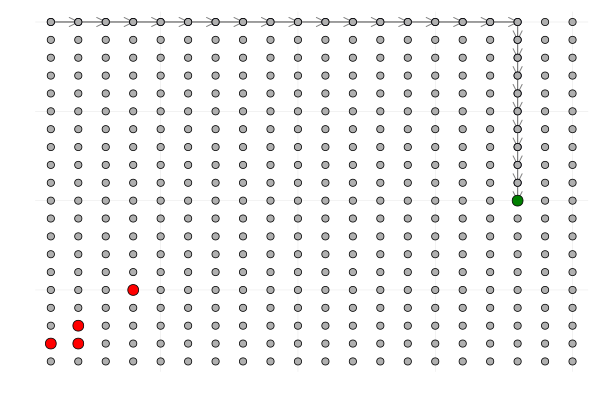

In [19]:
# draw the path -
p = plot();
s = (1,20);

visited_sites = Set{Tuple{Int,Int}}();
# push!(visited_sites, initial_site);

while (in(s, absorbing_state_set) == false)

    state = world.states[s];
    a = my_π[state];
    Δ = world.moves[a];
    s_next =  s .+ Δ

    scatter!([s[1]],[s[2]], label="", showaxis=:false, msc=:black, c=:blue)
    plot!([s[1], s_next[1]],[s[2], s_next[2]], label="", arrow=true, lw=1, c=:gray)
    
    if (haskey(world.states, s_next) == true)
        push!(visited_sites, s_next);
        s = s_next;
    end
end

# draw the grid -
for s ∈ 𝒮
    
    current_position = world.coordinates[s]
    a = my_π[s];
    Δ = world.moves[a];
    new_position =  current_position .+ Δ
    
    if (haskey(rewards, current_position) == true && rewards[current_position] == charging_reward)
        scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, c=:green, ms=6)
    elseif (haskey(rewards, current_position) == true && rewards[current_position] == lava_reward)
        scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, c=:red, ms=6)
    else (in(current_position, soft_wall_set) == true)
        scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, c=:gray69, ms=4)
    end
end
current()